# Strikeout the Stadiums #

#### Jonathan Dietrich (jrdietrich2@wisc.edu), Nathan Dimino (ndimino@wisc.edu), Sahib Nasrullayev (nasrullayev@wisc.edu)

### Table of Contents

1. [Introduction](#1.-Introduction)
1. [Mathematical Model](#2.-Mathematical-model)
1. [Solution](#3.-Solution)
1. [Results and Discussion](#4.-Results-and-discussion)
1. [Conclusion](#5.-Conclusion)

## 1. Introduction ##

For our project, we decided to try and apply linear optimization to something we’re actually passionate about which is baseball. More specifically, we really enjoy watching Major League Baseball and wanted to figure out the fastest possible way to visit all 30 MLB stadiums in one trip. My dad and I (Jonathan) have been trying to visit all 30 at least once together during our lives and we as a group thought this would be a good idea to help. My dad and I have visited 16 stadiums so far, but we thought with our model we could try to find a way to hit all of them in one singular trip. Of course, in real life we’d have to deal with things like game schedules, ticket prices, and days off, but for this model, we’re just focusing on travel time because the season is almost over, and it would not be possible with the remaining MLB schedule.

After doing some research, we came to find that this was a classic example of the traveling salesman problem, which we later learned about in class. The TSP, is about finding the shortest route to visit a bunch of different places exactly once and return to where you started. These ideas of problems like this go back to the 1800s with mathematicians Sir William Rowan Hamilton and Thomas Penyngton Kirkman, who were already looking at puzzles involving visiting all points in a network. In the 1930s, mathematicians like Karl Menger started studying the problem in the way that we do now, and later Hassler Whitney and Merrill Flood at Princeton helped make it more widely known. It has become a famous example in optimization because although the problem itself is fairly simple, we can save exponential amounts of time as we add more and more locations and data.

To set it up, we used a website linked below to calculate driving times from stadium to stadium. We used this specific website, because it is the only one that did not include traffic and because traffic is very unpredictable at times, we wanted to build our model assuming no traffic. The times went into a 30×30 matrix where each entry represents how many hours it would take to get from one stadium to another, assuming no traffic or delays. From there, we built a mathematical model in Julia using JuMP and solved it with the Gurobi optimizer. We used the Miller–Tucker–Zemlin formulation for our approach, which makes sure the route is one single loop instead of breaking into smaller disconnected loops. The solver then worked through all the possibilities and found the route with the lowest total travel time. Because the solution is a loop for the TSP, we are able to start anywhere and get the same total distance. So for our project, we wanted to start in Milwaukee, Wisconsin, home of the Brewers for obvious reasons. The rest of our report starts with explaining the math behind the model, then we go through how we implemented it in Julia, and finally we show the results, including the route, the total travel time, and a map showing the trip. We end up with some thoughts on what the results mean, what the model leaves out, and how we could make it more realistic in the future.

## 2. Mathematical model ##

We are modeling our problem as a traveling salesman problem, using the Miller-Tucker-Zemlin formulation to eliminate subtours.

**Sets and Parameters:**
- $ V $: the set of all 30 MLB stadiums
- $ N = |V| $: the number of stadiums in the set
- $ c_{ij} $: the estimated driving time in hours from stadium $i$ to stadium $ j $; each driving time symmetrical $(c_{ij} = c_{ji})$

**Decision Variables:**
- $ x_{ij} \in \{0,1\} $: 1 if we drive from city $ i $ to city $ j $, 0 if we decide not to
- $ u_i $: auxiliary integer variable representing the order in which stadium $i$ is visited in the trip, which is used to eliminate subtours

#### **Standard Form**
$$
\begin{aligned}
\min\quad 
  & \sum_{i\in V}\sum_{j\in V} c_{ij}\,x_{ij} \\[4pt]
\text{s.t.}\quad
  & \sum_{j\in V} x_{ij} = 1 && \forall i\in V \quad\text{(one arc leaves each city)}\\
  & \sum_{i\in V} x_{ij} = 1 && \forall j\in V \quad\text{(one arc enters each city)}\\
  & x_{ii} = 0 && \forall i\in V \quad\text{(no self-loops)}\\[4pt]
  & u_i - u_j + N\,x_{ij} \le N-1 
      && \forall i\in V,\ \forall j\in V\setminus\{1\},\ i\ne j \quad\text{(MTZ subtour elimination)}\\[2pt]
  & u_1 = 0,\quad 1\le u_i \le N-1 && \forall i\in V\setminus\{1\} \\[2pt]
  & x_{ij}\in\{0,1\} && \forall i,j\in V
\end{aligned}
$$


The constraints make sure that only one arc leaves each stadium and one arc enters each stadium. This is because we want exactly one trip segment departing from each stadium and exactly one trip segment arriving at each stadium. There is a constraint to prevent self-loops, which obviously don't accomplish anything. The MTZ subtour elimination constraint is so that all of the stadiums must are part of the same continuous tour and the variable bounds make sure the $u_i$ values are valid position numbers in the tour order. We are assuming in this model that there is no traffic or any delays.

## 3. Solution ##

### 3.A. Our Data
![data](data.png)

In [1]:
using JuMP, NamedArrays, Gurobi   #Load packages

mlb_teams_abbreviations = Dict(     #Dictionary of all 30 MLB teams with the team abbreviations
    "Arizona Diamondbacks" => :ARZ,
    "Athletics" => :ATH,
    "Atlanta Braves" => :ATL,
    "Baltimore Orioles" => :BAL,
    "Boston Red Sox" => :BOS,
    "Chicago Cubs" => :CHC,
    "Cincinnati Reds" => :CIN,
    "Cleveland Guardians" => :CLE,
    "Colorado Rockies" => :COL,
    "Chicago White Sox" => :CWS,
    "Detroit Tigers" => :DET,
    "Houston Astros" => :HOU,
    "Kansas City Royals" => :KCR,
    "Los Angeles Angels" => :LAA,
    "Los Angeles Dodgers" => :LAD,
    "Miami Marlins" => :MIA,
    "Milwaukee Brewers" => :MIL,
    "Minnesota Twins" => :MIN,
    "New York Mets" => :NYM,
    "New York Yankees" => :NYY,
    "Philadelphia Phillies" => :PHI,
    "Pittsburgh Pirates" => :PIT,
    "San Diego Padres" => :SDP,
    "Seattle Mariners" => :SEA,
    "San Francisco Giants" => :SFG,
    "St. Louis Cardinals" => :STL,
    "Tampa Bay Rays" => :TBR,
    "Texas Rangers" => :TEX,
    "Toronto Blue Jays" => :TOR,
    "Washington Nationals" => :WAS,
);

teams = sort(collect(values(mlb_teams_abbreviations)))   #Extract just abbreviations from the dictionary to use as labels for our matrix


#Symmetric 30x30 distance matrix with driving times between MLB stadiums
driving_times = [   0	    4.767	25.767	32.283	38.217	25.283	25.300	28.417	12.283	24.550	28.033	16.417	17.967	5.250	5.967	33.050	25.483	23.967	34.800	34.650	33.433	29.050	5.367	20.817	11.767	20.450	29.833	14.533	33.000	33.000
                4.767	0	    27.517	33.867	38.400	24.450	26.983	29.150	10.683	24.283	28.050	20.600	18.683	3.967	4.033	36.217	24.817	22.983	36.183	35.917	34.900	30.633	4.950	16.483	8.733	22.133	33.267	17.400	33.000	34.217
                25.767	27.517	0	    10.200	17.383	10.383	6.433	9.833	19.567	10.150	10.067	11.333	11.167	30.300	30.400	9.483	11.583	16.000	13.450	13.183	11.417	10.367	29.667	27.000	34.917	8.000	6.617	11.400	14.717	9.400
                32.283	33.867	10.200	0	    6.050	10.700	7.617	5.517	23.383	10.267	7.650	20.750	15.283	37.683	37.750	15.700	11.817	16.367	3.167	3.017	1.550	3.800	37.367	39.083	40.633	12.000	13.600	19.483	7.933	0.683
                38.217	38.400	17.383	6.050	0	    15.200	12.750	9.333	28.750	14.650	11.767	27.033	20.400	42.833	42.783	21.850	16.817	21.300	3.283	3.233	4.933	8.800	42.600	43.900	44.417	17.150	20.100	25.700	8.583	6.900
                25.283	24.450	10.383	10.700	15.200	0	    4.750	5.433	14.617	0.300	4.350	15.950	7.650	28.733	28.750	20.017	1.667	6.017	12.983	12.050	11.950	7.333	29.567	28.850	30.067	4.617	17.300	14.250	8.167	11.300
                25.300	26.983	6.433	7.617	12.750	4.750	0	    3.600	16.783	4.383	3.850	15.350	8.250	31.183	30.567	16.000	5.750	10.167	10.133	9.683	8.783	4.333	30.750	33.050	26.217	5.100	12.900	13.500	7.650	7.867
                28.417	29.150	9.833	5.517	9.333	5.433	3.600	0	    18.750	5.200	2.550	18.767	11.167	32.700	32.783	17.883	6.583	11.000	7.183	7.000	6.517	2.050	33.667	33.867	34.667	7.917	16.133	17.200	4.583	5.867
                12.283	10.683	19.567	23.383	28.750	14.617	16.783	18.750	0	    14.367	18.167	15.283	8.250	14.617	15.283	29.350	14.433	12.717	25.967	25.850	24.567	20.500	15.883	18.800	12.867	11.867	26.267	11.500	22.300	11.867
                24.550	24.283	10.150	10.267	14.650	0.300	4.383	5.200	14.367	0	    13.983	15.700	7.450	28.567	28.700	19.883	1.500	6.017	12.067	11.800	11.450	6.817	29.533	28.900	29.717	4.317	17.033	14.017	7.900	10.667
                28.033	28.050	10.067	7.650	11.767	4.350	3.850	2.550	18.167	13.983	0	    18.817	10.833	31.783	31.933	19.817	5.517	9.917	9.450	9.217	8.700	4.200	32.717	32.783	33.283	7.583	16.967	17.233	3.767	7.983
                16.417	20.600	11.333	20.750	27.033	15.950	15.350	18.767	15.283	15.700	18.817	0	    10.883	21.033	21.300	16.900	16.867	17.150	23.817	23.650	22.133	19.300	20.150	33.300	26.650	11.700	14.050	3.750	23.283	20.233
                17.967	18.683	11.167	15.283	20.400	7.650	8.250	11.167	8.250	7.450	10.833	10.883	0	    22.750	22.883	21.000	7.917	6.367	17.900	17.717	16.533	12.133	22.933	26.017	25.350	3.700	18.133	8.000	14.850	15.633
                5.250	3.967	30.300	37.683	42.833	28.733	31.183	32.700	14.617	28.567	31.783	21.033	22.750	0	    0.567	37.517	28.017	26.417	39.033	38.850	37.683	33.517	1.600	18.233	6.950	25.050	34.750	19.533	36.000	36.717
                5.967	4.033	30.400	37.750	42.783	28.750	30.567	32.783	15.283	28.700	31.933	21.300	22.883	0.567	0	    39.183	29.633	26.533	41.267	38.983	39.550	35.383	2.617	16.800	7.750	26.533	35.133	19.833	37.000	38.817
                33.050	36.217	9.483	15.700	21.850	20.017	16.000	17.883	29.350	19.883	19.817	16.900	21.000	37.517	39.183	0	    21.767	25.500	19.383	18.400	17.383	17.100	37.017	46.900	43.633	17.667	4.517	19.083	22.167	14.950
                25.483	24.817	11.583	11.817	16.817	1.667	5.750	6.583	14.433	1.500	5.517	16.867	7.917	28.017	29.633	21.767	0	    4.933	13.867	13.850	13.133	8.433	29.567	27.600	29.967	5.267	18.667	14.667	9.250	12.933
                23.967	22.983	16.000	16.367	21.300	6.017	10.167	11.000	12.717	6.017	9.917	17.150	6.367	26.417	26.533	25.500	4.933	0	    17.883	17.683	17.150	12.850	28.417	23.233	28.650	8.617	22.050	13.700	14.050	16.400
                34.800	36.183	13.450	3.167	3.283	12.983	10.133	7.183	25.967	12.067	9.450	23.817	17.900	39.033	41.267	19.383	13.867	17.883	0	    0.683	1.983	6.133	40.300	41.700	42.167	14.500	18.050	23.550	8.083	3.967
                34.650	35.917	13.183	3.017	3.233	12.050	9.683	7.000	25.850	11.800	9.217	23.650	17.717	38.850	38.983	18.400	13.850	17.683	0.683	0	    2.533	6.433	40.425	40.917	41.617	15.000	17.750	22.967	8.267	4.750
                33.433	34.900	11.417	1.550	4.933	11.950	8.783	6.517	24.567	11.450	8.700	22.133	16.533	37.683	39.550	17.383	13.133	17.150	1.983	2.533	0	    4.833	39.083	39.833	41.500	13.300	16.150	21.750	8.350	2.483
                29.050	30.633	10.367	3.800	8.800	7.333	4.333	2.050	20.500	6.817	4.200	19.300	12.133	33.517	35.383	17.100	8.433	12.850	6.133	6.433	4.833	0	    34.533	35.367	36.567	8.833	15.267	18.000	5.583	4.000
                5.367	4.950	29.667	37.367	42.600	29.567	30.750	33.667	15.883	29.533	32.717	20.150	22.933	1.600	2.617	37.017	29.567	28.417	40.300	40.425	39.083	34.533	0	    19.617	7.767	25.333	33.433	18.383	38.000	27.683
                20.817	16.483	27.000	39.083	43.900	28.850	33.050	33.867	18.800	28.900	32.783	33.300	26.017	18.233	16.800	46.900	27.600	23.233	41.700	40.917	39.833	35.367	19.617	0	    14.833	29.717	43.583	29.483	38.000	39.650
                11.767	8.733	34.917	40.633	44.417	30.067	26.217	34.667	12.867	29.717	33.283	26.650	25.350	6.950	7.750	43.633	29.967	28.650	42.167	41.617	41.500	36.567	7.767	14.833	0	    29.100	39.983	24.500	38.000	40.533
                20.450	22.133	8.000	12.000	17.150	4.617	5.100	7.917	11.867	4.317	7.583	11.700	3.700	25.050	26.533	17.667	5.267	8.617	14.500	15.000	13.300	8.833	25.333	29.717	29.100	0	    14.717	9.550	11.500	13.150
                29.833	33.267	6.617	13.600	20.100	17.300	12.900	16.133	26.267	17.033	16.967	14.050	18.133	34.750	35.133	4.517	18.667	22.050	18.050	17.750	16.150	15.267	33.433	43.583	39.983	14.717	0	    16.033	20.433	12.983
                14.533	17.400	11.400	19.483	25.700	14.250	13.500	17.200	11.500	14.017	17.233	3.750	8.000	19.533	19.833	19.083	14.667	13.700	23.550	22.967	21.750	18.000	18.383	29.483	24.500	9.550	16.033	0	    21.100	19.267
                33.000	33.000	14.717	7.933	8.583	8.167	7.650	4.583	22.300	7.900	3.767	23.283	14.850	36.000	37.000	22.167	9.250	14.050	8.083	8.267	8.350	5.583	38.000	38.000	38.000	11.500	20.433	21.100	0	    9.133
                33.000	34.217	9.400	0.683	6.900	11.300	7.867	5.867	11.867	10.667	7.983	20.233	15.633	36.717	38.817	14.950	12.933	16.400	3.967	4.750	2.483	4.000	27.683	39.650	40.533	13.150	12.983	19.267	9.133	0     ]

c = NamedArray(driving_times,(teams, teams))   #Store the matrix as a NamedArray, adding the team abbreviations as labels
N = size(driving_times,1); #Number of stadiums

### 3.B. Eliminating subtours functions

In [2]:
#This function finds the sequence of the cities in a subtour
function getSubtour(x,start)
    subtour = [start]
    while true
        j = subtour[end]
        for k in teams
            if x[k,j] == 1
                push!(subtour,k)
                break
            end
        end
        if subtour[end] == start
            break
        end
    end
    return subtour
end

#This function finds all subtours for the current solution
function getAllSubtours(x)
    nodesRemaining = teams
    subtours = []
    while length(nodesRemaining) > 0
        subtour = getSubtour(x,nodesRemaining[1])
        push!(subtours, subtour)
        nodesRemaining = setdiff(nodesRemaining,subtour)
    end
    return subtours
end
;

### 3.C. The Model

In [3]:
model = Model(Gurobi.Optimizer)

@variable(model, x[teams,teams], Bin)   # A binary variable that is 1 if we travel from i to j, and 0 otherwise
@variable(model, u[teams])   # The ordering variable for each city

@objective(model, Min, sum(x[i,j]*c[i,j] for i in teams, j in teams))   #Minimizing the total travel time

@constraint(model, c1[j in teams], sum(x[i,j] for i in teams) == 1)   #Ensures we visit each stadium one time exactly
@constraint(model, c2[i in teams], sum(x[i,j] for j in teams) == 1)   #Ensures we leave each stadium one time exactly
@constraint(model, c3[i in teams], x[i,i] == 0)   #Ensures there are no self-loops, so we don't travel from one stadium to itself
@constraint(model, c4[i in teams, j in teams[2:end]], u[i] - u[j] + N*x[i,j] <= N-1)   # Eliminates subtours

#Optimize the model to find and extract our most optimal route
set_silent(model)
optimize!(model)
xx = value.(x)
optimal_route = getAllSubtours(xx)
println(optimal_route)

Set parameter Username
Set parameter LicenseID to value 2694049
Academic license - for non-commercial use only - expires 2026-08-06
Any[[:ARZ, :ATH, :LAD, :LAA, :SDP, :SFG, :SEA, :COL, :KCR, :STL, :MIN, :MIL, :CWS, :CHC, :DET, :TOR, :BOS, :NYY, :NYM, :PHI, :BAL, :WAS, :PIT, :CLE, :CIN, :ATL, :TBR, :MIA, :HOU, :TEX, :ARZ]]


### 3.D. Starting the route at any stadium, we start in Milwaukee

In [4]:
# Function to order the route starting from a chosen city
function ordered_route(start)
    route = [start]
    while length(route) < N+1
        current = route[end]
        next_city = first([j for j in teams if xx[current,j] > 0.5])
        push!(route, next_city)
    end
    return route
end

#Set our route to start at the Brewers stadium in Milwaukee
our_optimal_route = ordered_route(:MIL)
println(our_optimal_route)

[:MIL, :MIN, :STL, :KCR, :COL, :SEA, :SFG, :SDP, :LAA, :LAD, :ATH, :ARZ, :TEX, :HOU, :MIA, :TBR, :ATL, :CIN, :CLE, :PIT, :WAS, :BAL, :PHI, :NYM, :NYY, :BOS, :TOR, :DET, :CHC, :CWS, :MIL]


## 4. Results and discussion ##

### 4.A. Most Optimal Route In Order Starting In Milwaukee

1. American Family Field (Milwaukee, WI)
2. Target Field (Minneapolis, MN)
3. Busch Stadium (St. Louis, MO)
4. Kauffman Stadium (Kansas City, MO)
5. Coors Field (Denver, CO)
6. T-Mobile Park (Seattle, WA)
7. Oracle Park (San Francisco, CA)
8. Petco Park (San Diego, CA)
9. Angel Stadium (Anaheim, CA)
10. Dodger Stadium (Los Angeles, CA)
11. Sutter Health Park (West Sacramento, CA)
12. Chase Field (Phoenix, AZ)
13. Globe Life Field (Arlington, TX)
14. Daikin Park (Houston, TX)
15. LoanDepot Field (Miami, FL)
16. George M. Steinbrenner Field (Tampa, FL)
17. Truist Park (Atlanta, GA)
18. Great American Ball Park (Cincinnati, OH)
19. Progressive Field (Cleveland, OH)
20. PNC Park (Pittsburgh, PA)
21. Nationals Park (Washington, DC)
22. Oriole Park at Camden Yards (Baltimore, MD)
23. Citizens Bank Park (Philadelphia, PA)
24. Citi Field (Flushing, NY)
25. Yankee Stadium (Bronx, NY)
26. Fenway Park (Boston, MA)
27. Rogers Centre (Toronto, ON, Canada)
28. Comerica Park (Detroit, MI)
29. Wrigley Field (Chicago, IL)
30. Rate Field (Chicago, IL)
31. American Family Field (Milwaukee, WI)

In [5]:
println("Expected trip time without stoppages: ", round(objective_value(model), digits=3), " hours or ",round(objective_value(model)/24, digits=3), " days")

Expected trip time without stoppages: 166.899 hours or 6.954 days


### 4.B. A Map Of Our Route

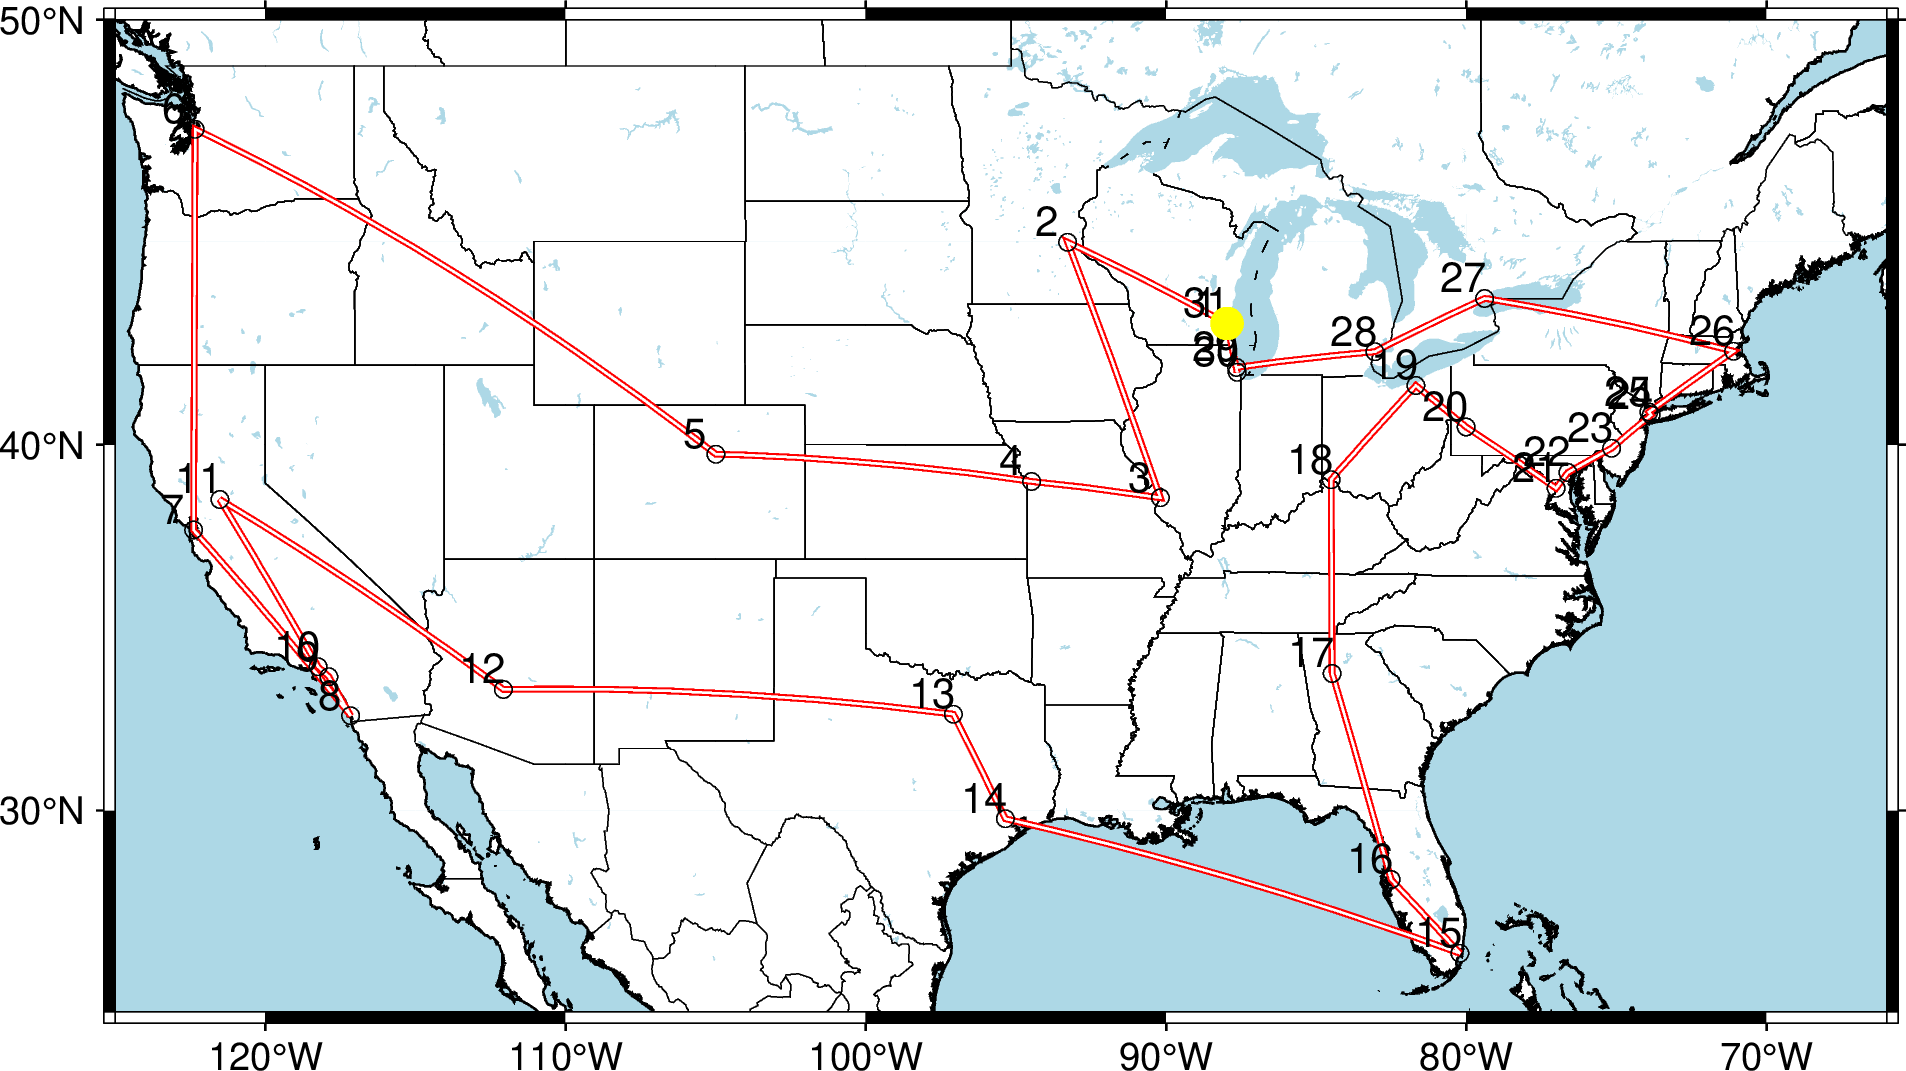

In [6]:
using GMT

coords = Dict(
    :ARZ => (33.4455, -112.0667), # Chase Field
    :LAA => (33.8003, -117.8827), # Angel Stadium
    :LAD => (34.0739, -118.2390), # Dodger Stadium
    :SDP => (32.7076, -117.1570), # Petco Park
    :SFG => (37.7786, -122.3893), # Oracle Park
    :SEA => (47.5914, -122.3325), # T-Mobile Park
    :COL => (39.7561, -104.9942), # Coors Field
    :KCR => (39.0517, -94.4803),  # Kauffman Stadium
    :STL => (38.6226, -90.1928),  # Busch Stadium
    :MIN => (44.9817, -93.2783),  # Target Field
    :MIL => (43.0280, -87.9712),  # American Family Field
    :CWS => (41.8300, -87.6339),  # Guaranteed Rate Field
    :CHC => (41.9484, -87.6553),  # Wrigley Field
    :DET => (42.3390, -83.0485),  # Comerica Park
    :TOR => (43.6414, -79.3894),  # Rogers Centre
    :BOS => (42.3467, -71.0972),  # Fenway Park
    :NYY => (40.8296, -73.9262),  # Yankee Stadium
    :NYM => (40.7571, -73.8458),  # Citi Field
    :PHI => (39.9058, -75.1665),  # Citizens Bank Park
    :BAL => (39.2839, -76.6217),  # Camden Yards
    :WAS => (38.8730, -77.0074),  # Nationals Park
    :PIT => (40.4469, -80.0057),  # PNC Park
    :CLE => (41.4957, -81.6853),  # Progressive Field
    :CIN => (39.0974, -84.5071),  # Great American Ball Park
    :ATL => (33.8908, -84.4678),  # Truist Park
    :TBR => (27.9803, -82.5064),  # George M. Steinbrenner Field
    :MIA => (25.7781, -80.2197),  # loanDepot Park
    :HOU => (29.7572, -95.3554),  # Minute Maid Park
    :TEX => (32.7512, -97.0820),  # Globe Life Field
    :ATH => (38.5798, -121.5148)  # Sutter Health Park
)

route = our_optimal_route
lats = [coords[city][1] for city in route]
lons = [coords[city][2] for city in route]

gmtbegin()

coast(region=(-125,-66,24,50), proj=:Mercator, frame=:a, # Adds the map with state and country borders
      shorelines="1/0.5p,black", borders=(2, 0.25),
      land=:white, water=:lightblue, res=:i)
coast(region=(-125,-66,24,50), borders=(1,0.25))

plot(lons, lats, pen="1.5p,red") # Adds the line representing the driving route
scatter(lons, lats, size="0.15c", pen="0.5p,white") # Adds circles at each city

labels = string.(1:length(route))
text(labels; x=lons, y=lats, font=(10,:black), offset="-0.18c/0.18c") # Adds the number order the stadium is visited in

scatter([lons[1]], [lats[1]], size="0.28c", fill=:yellow, pen=:black)   # Add yellow starting point in Milwaukee

gmtend(show=true)

### 4.C. Our Thoughts

We found that he solver produced an optimal tour with a total travel time of 166.899 hours. We began and ended the route in Milwaukee, and visited every MLB stadium exactly once without revisiting any. Starting from Milwaukee, the trip first heads north and west to Minneapolis, MN before making its way through the midwest, then up northwest to Seattle, down the California coastline to the southeast. The trip then heads east across the south to Florida, then up through the east coast to the upper northeast, then back west towards Milwaukee. The flow makes sense geographically, as it minimizes backtracking and clusters visits to nearby stadiums. It seems that the order is practical in that it would allow us to see multiple stadiums in the same region back-to-back like the New York Yankees and New York Mets, or Los Angeles Dodgers and Los Angeles Angels. The solver naturally found a pattern that makes intuitive sense for travel.

However, there are few limitations to our current model that would need to be addressed before turning this into a real trip plan. The first being traffic. We assumed constant driving speeds and no traffic, which is unrealistic in cities like Los Angeles or New York, but this can be quite hard to predict at times. The next problem would be that in reality, stadium visits would be constrained by home game schedules, which would definitely force extra waiting days and add time. Lastly, our model treats the trip as continuous driving with no overnight breaks, which would not be possible with the trip spanning over multiple days just in driving time.

## 5. Conclusion ##

In this project, we were able to model and solve the problem of finding the fastest route to visit all 30 Major League Baseball stadiums. Using the Miller–Tucker–Zemlin formulation in JuMP with Gurobi, we minimized total driving time based on a 30×30 travel time matrix that assumed no traffic or delays. We started in Milwaukee and the route proceeds in a loop around the country that makes sense geographically, visiting each stadium exactly once before returning to the starting point. The final route minimizes backtracking and keeps stadiums in similar regions grouped together, resulting in a total travel time of 166.899 hours. A future direction we could go with this project is we think it would be interesting to expand this model into a TSP that uses actual MLB game schedules. This would mean adding constraints so that each stadium is only visited on a date when the home team is playing, while also trying to minimize the travel time between games. We were also thinking we could also allow flying by plane for some of the trips if it reduces overall time. It would make the model a lot more complex but it would make the plan a lot more realistic and feasible to do one summer in the future.